## This notebook shows few simple benchmarks to predict land cover classes for TiSeLaC Challenge: https://sites.google.com/site/dinoienco/tiselc

In [4]:
# basic libraries import
import pandas as pd
import numpy as np
from sklearn import ensemble, metrics, cluster, neighbors
import matplotlib.pyplot as plt
%matplotlib inline

# this is custom file, made for shrink notebook size
import utils

# score function wrapper
def f1_scorew(y_true, y_pred):
    return metrics.f1_score(y_true, y_pred, average='weighted')

# EDIT HERE, the path to data files
DATA_PATH='.\\'
DATA_PATH='c:\\p\\dm\\dinoienco\\data\\'

# reading data
train = pd.read_csv(DATA_PATH+'training.txt', header=None).astype(np.int16)
train_scaled = pd.read_csv(DATA_PATH+'train_scaled.csv').astype(np.float32)
test = pd.read_csv(DATA_PATH+'test.dat', header=None)
coord_train = pd.read_csv(DATA_PATH+'coord_training.txt', header=None, names=['x1','x2'])
coord_test = pd.read_csv(DATA_PATH+'coord_test.dat', header=None, names=['x1','x2'])
y_train = pd.read_csv(DATA_PATH+'training_class.txt', header=None, names=['y'])['y']
y_test = pd.read_csv(DATA_PATH+'test.cl', header=None, names=['y'])['y']

#metadata
n_features=10
n_periods=23
classes=y_train.unique()
n_classes=classes.shape[0]
n=train.shape[0]
class_names={1.:'Urban Areas',2.:'Other built-up surfaces',3.:'Forests',4.:'Sparse Vegetation',5:'Rocks and bare soil',6.:'Grassland',7.:'Sugarcane crops',8.:'Other crops',9:'Water'}

## We'll use Extremely Randomized Trees Classifier to check most of approaches

In [5]:
clf=ensemble.ExtraTreesClassifier(n_estimators=30)

In [6]:
n=5000
train=train.iloc[:n]
y_train=y_train.iloc[:n]
coord_train=coord_train.iloc[:n]
train_scaled=train_scaled.iloc[:n]

In [7]:
# trace all model scores 
all_scores=pd.DataFrame(columns=['clf', 'description','cv','score_mean'])

## the following five cross-validation schemes will be used:
* random split train and test
* split train and test by rectangles (in one rectange only train or test)
* subsample train (or decrease it's size)

In [8]:
origCV=utils.SubsampleTrainCV(n, train_ratio=1.)
rectCV=utils.LandRectanglesCV(coord_train)
ss07CV=utils.SubsampleTrainCV(n, train_ratio=.7)
ss04CV=utils.SubsampleTrainCV(n, train_ratio=.4)
ss01CV=utils.SubsampleTrainCV(n, train_ratio=.1)

## Simplest benchmark: no preprocessing

In [26]:
for _cv in [origCV, rectCV, ss07CV, ss04CV, ss01CV]:
    res=utils.test_cv(train, y_train, clf, _cv, f1_scorew, 'base benchmark')
    all_scores=all_scores.append(res)
all_scores.iloc[-5:]

time: 121.63s
time: 122.40s
time: 77.25s
time: 40.96s
time: 10.37s


,clf,description,cv,score_mean
0,"ExtraTreesClassifier(bootstrap=False, class_we...",base benchmark,subs1.0CV,0.8893
0,"ExtraTreesClassifier(bootstrap=False, class_we...",base benchmark,rectCV,0.7797
0,"ExtraTreesClassifier(bootstrap=False, class_we...",base benchmark,subs0.7CV,0.8824
0,"ExtraTreesClassifier(bootstrap=False, class_we...",base benchmark,subs0.4CV,0.8719
0,"ExtraTreesClassifier(bootstrap=False, class_we...",base benchmark,subs0.1CV,0.8409


## Check for KNN, but with ZMUV scaled data

In [ ]:
clf=neighbors.KNeighborsClassifier(n_neighbors=10)
for _cv in [origCV, rectCV, ss07CV, ss04CV, ss01CV]:
    res=utils.test_cv(train_scaled, y_train, clf, _cv, f1_scorew, 'base benchmark ZMUV+10NN')
    all_scores=all_scores.append(res)
all_scores.iloc[-5:]

## Here we trying to extract temporal shapes with MiniBatchKMeans clustering, no Fourier analysis or convolutions tried here, due to only one year time series we have

### The following number of clusters will be tried

In [9]:
clusters_range=[1]+list(range(5,81,5))
clusters_range

[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

### Here also two different types of how to cluster time series:
* consider feature dynamics is one observation with 'n_periods'-dimensional space
* consider every snapshot as one observation with 'n_features'-dimensional space

In [ ]:
clusters_scores_features=pd.DataFrame(columns=['clf', 'description','cv','score_mean'])
for n_cl in clusters_range:
    tcf=utils.TimedCluster(cluster.MiniBatchKMeans(n_clusters=n_cl), feature_space='features')
    train_clusters_features=tcf.fit_predict(train)
    res=utils.test_cv(train_clusters_features, y_train, clf, origCV, f1_scorew, 'cluster features n_clusters={}'.format(n_cl))
    clusters_scores_features=clusters_scores_features.append(res)
clusters_scores_features['n_clusters']=clusters_range

In [ ]:
clusters_scores_periods=pd.DataFrame(columns=['clf', 'description','cv','score_mean'])
for n_cl in clusters_range:
    tcp=utils.TimedCluster(cluster.MiniBatchKMeans(n_clusters=n_cl), feature_space='periods')
    train_clusters_periods=tcp.fit_predict(train_scaled)
    res=utils.test_cv(train_clusters_periods, y_train, clf, origCV, f1_scorew, 'cluster periods n_clusters={}'.format(n_cl))
    clusters_scores_periods=clusters_scores_periods.append(res)
clusters_scores_periods['n_clusters']=clusters_range

### Let's check how number of clusters affect score, with plots

In [11]:
plt.rcParams['axes.labelsize']=14
plt.rcParams['axes.titlesize']=14

In [ ]:
clusters_scores_features.plot(x='n_clusters', y='score_mean', figsize=(6,4), title='F1score weighted CV', legend=False, grid=True, fontsize=12)
plt.tight_layout()
plt.savefig(DATA_PATH+'feature_clustering_cv.pdf', format='pdf', dpi=500)

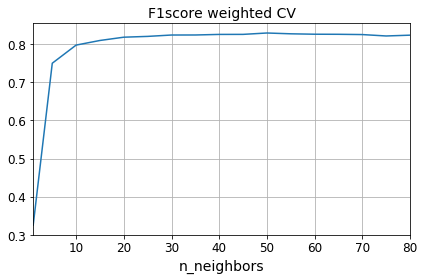

In [32]:
clusters_scores_periods.plot(x='n_clusters', y='score_mean', figsize=(6,4), title='F1score weighted CV', legend=False, grid=True, fontsize=12)
plt.tight_layout()
plt.savefig(DATA_PATH+'snapshot_clustering_cv.pdf', format='pdf', dpi=500)

In [27]:
clusters_scores_features.iloc[np.argmax(clusters_scores_features['score_mean'].values)]

clf            ExtraTreesClassifier(bootstrap=False, class_we...
description                       cluster features n_clusters=65
cv                                                     subs1.0CV
score_mean                                                0.8164
n_neighbors                                                   65
Name: 0, dtype: object

In [28]:
clusters_scores_periods.iloc[np.argmax(clusters_scores_periods['score_mean'].values)]

clf            ExtraTreesClassifier(bootstrap=False, class_we...
description                        cluster periods n_clusters=50
cv                                                     subs1.0CV
score_mean                                                0.8294
n_neighbors                                                   50
Name: 0, dtype: object

### Best n_clusters values pass through different cross-validation schemes:

In [101]:
n_cl=clusters_scores_features.iloc[np.argmax(clusters_scores_features['score_mean'].values)]['n_neighbors']
tcf=utils.TimedCluster(cluster.MiniBatchKMeans(n_clusters=n_cl), feature_space='features')
train_clusters_features=tcf.fit_predict(train)
for _cv in [origCV, rectCV, ss07CV, ss04CV, ss01CV]:
    res=utils.test_cv(train_clusters_features, y_train, clf, _cv, f1_scorew, 'feature clusters={}'.format(n_cl))
    all_scores=all_scores.append(res)
all_scores.iloc[-5:]

time: 29.46s
time: 29.97s
time: 19.67s
time: 10.78s
time: 4.04s


,clf,description,cv,score_mean
0,"ExtraTreesClassifier(bootstrap=False, class_we...",feature clusters=61,subs1.0CV,0.8185
0,"ExtraTreesClassifier(bootstrap=False, class_we...",feature clusters=61,rectCV,0.7063
0,"ExtraTreesClassifier(bootstrap=False, class_we...",feature clusters=61,subs0.7CV,0.8092
0,"ExtraTreesClassifier(bootstrap=False, class_we...",feature clusters=61,subs0.4CV,0.7938
0,"ExtraTreesClassifier(bootstrap=False, class_we...",feature clusters=61,subs0.1CV,0.7490


In [102]:
n_cl=clusters_scores_periods.iloc[np.argmax(clusters_scores_periods['score_mean'].values)]['n_neighbors']
tcp=utils.TimedCluster(cluster.MiniBatchKMeans(n_clusters=n_cl), feature_space='periods')
train_clusters_periods=tcp.fit_predict(train_scaled)
for _cv in [origCV, rectCV, ss07CV, ss04CV, ss01CV]:
    res=utils.test_cv(train_clusters_periods, y_train, clf, _cv, f1_scorew, 'periods clusters={}'.format(n_cl))
    all_scores=all_scores.append(res)
all_scores.iloc[-5:]

time: 37.22s
time: 36.75s
time: 24.18s
time: 13.61s
time: 4.37s


,clf,description,cv,score_mean
0,"ExtraTreesClassifier(bootstrap=False, class_we...",periods clusters=41,subs1.0CV,0.8294
0,"ExtraTreesClassifier(bootstrap=False, class_we...",periods clusters=41,rectCV,0.7314
0,"ExtraTreesClassifier(bootstrap=False, class_we...",periods clusters=41,subs0.7CV,0.8223
0,"ExtraTreesClassifier(bootstrap=False, class_we...",periods clusters=41,subs0.4CV,0.8116
0,"ExtraTreesClassifier(bootstrap=False, class_we...",periods clusters=41,subs0.1CV,0.7816


## Embedding observations with nearest neighbors features

In [4]:
# We need to add coordinates to data for use NearestPointEmbedding transformer
trainx1x2=train.copy()
trainx1x2[coord_train.columns]=coord_train

### try different number of neighbors: 2,5,10

In [ ]:
n_neighbors=2
npe=utils.NearestPointsEmbedding(n_neighbors=n_neighbors)
for _cv in [origCV1, rectCV1, ss07CV1, ss04CV1, ss01CV1]:
    res=utils.test_cv_transform(trainx1x2, y_train, clf, _cv, f1_scorew, 'embedding neighbors={}'.format(n_neighbors), npe)
    all_scores=all_scores.append(res)
all_scores.iloc[-5:]

In [ ]:
n_neighbors=5
npe=utils.NearestPointsEmbedding(n_neighbors=n_neighbors)
for _cv in [origCV1, rectCV1, ss07CV1, ss04CV1, ss01CV1]:
    res=utils.test_cv_transform(trainx1x2, y_train, clf, _cv, f1_scorew, 'embedding neighbors={}'.format(n_neighbors), npe)
    all_scores=all_scores.append(res)
all_scores.iloc[-5:]

In [ ]:
n_neighbors=10
npe=utils.NearestPointsEmbedding(n_neighbors=n_neighbors)
for _cv in [origCV1, rectCV1, ss07CV1, ss04CV1, ss01CV1]:
    res=utils.test_cv_transform(trainx1x2, y_train, clf, _cv, f1_scorew, 'embedding neighbors={}'.format(n_neighbors), npe)
    all_scores=all_scores.append(res)
all_scores.iloc[-5:]

## Simple, but strong: coordinate-based nearest neighbors classifier

In [18]:
n_neighbors=1
clf=neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform', p=1)
for _cv in [origCV, rectCV, ss07CV, ss04CV, ss01CV]:
    res=utils.test_cv(coord_train, y_train, clf, _cv, f1_scorew, 'knn on coordinates neighbors={}'.format(n_neighbors))
    all_scores=all_scores.append(res)
all_scores.iloc[-5:]

time: 2.09s
time: 2.42s
time: 1.52s
time: 1.23s
time: 0.95s


,clf,description,cv,score_mean
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",knn on coordinates neighbors=1,subs1.0CV,0.9850
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",knn on coordinates neighbors=1,rectCV,0.5804
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",knn on coordinates neighbors=1,subs0.7CV,0.9787
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",knn on coordinates neighbors=1,subs0.4CV,0.9663
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",knn on coordinates neighbors=1,subs0.1CV,0.9071


In [21]:
n_neighbors=2
clf=neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
for _cv in [origCV, rectCV, ss07CV, ss04CV, ss01CV]:
    res=utils.test_cv(coord_train, y_train, clf, _cv, f1_scorew, 'knn on coordinates neighbors={}'.format(n_neighbors))
    all_scores=all_scores.append(res)
all_scores.iloc[-5:]

time: 2.27s
time: 2.40s
time: 1.47s
time: 1.27s
time: 1.02s


,clf,description,cv,score_mean
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",knn on coordinates neighbors=2,subs1.0CV,0.9789
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",knn on coordinates neighbors=2,rectCV,0.5951
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",knn on coordinates neighbors=2,subs0.7CV,0.9716
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",knn on coordinates neighbors=2,subs0.4CV,0.9553
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",knn on coordinates neighbors=2,subs0.1CV,0.8875


In [ ]:
n_neighbors=10
clf=neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
for _cv in [origCV, rectCV, ss07CV, ss04CV, ss01CV]:
    res=utils.test_cv(coord_train, y_train, clf, _cv, f1_scorew, 'knn on coordinates neighbors={}'.format(n_neighbors))
    all_scores=all_scores.append(res)
all_scores.iloc[-5:]